In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 6.0)
from cmocean import cm

import numpy as np
import patsy as pt
import pandas as pd
import theano.tensor as T
import pymc3 as pm

# regenerate same fake data

In [2]:
N_data = 1000
x = np.linspace(0,1,N_data)
data = pd.DataFrame({"x": x})
Z = pt.dmatrix("bs(x,4)", data)
true_alpha = np.array([1.0, 2.1, -2.4, 2.5, -2.5])

def var_of_x(x_prime, alpha):
    """ returns sigma2(x) """
    Z_prime = pt.build_design_matrices([Z.design_info], {"x": x_prime})[0]
    sigma2 = np.exp(np.dot(Z_prime, alpha))
    return sigma2

def sample_y(x_prime, alpha):
    sigma2 = var_of_x(x_prime, alpha)
    y = np.random.randn(len(x_prime)) * np.sqrt(sigma2)
    return y


sigma2 = var_of_x(x, true_alpha)
y = sample_y(x, true_alpha)

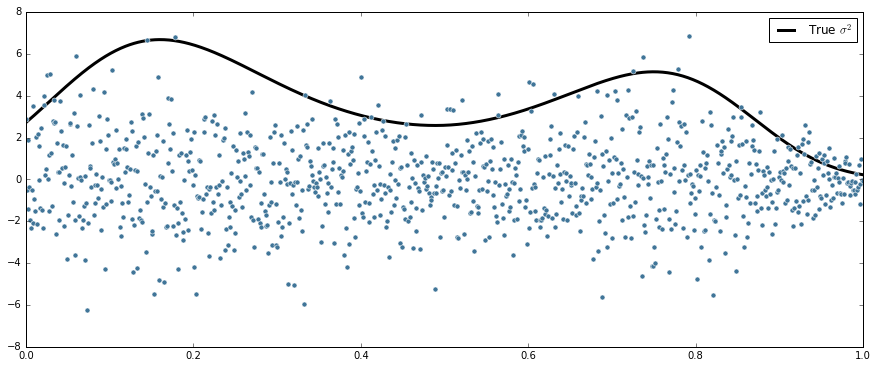

In [3]:
plt.plot(x, sigma2, "k", lw=3, label="True $\sigma^2$")
plt.plot(x, y, 'o', color=cm.deep(0.6), mec="white", ms=5)
plt.legend()

# set up pymc3 model

In [4]:
with pm.Model() as model:
    alpha = pm.Normal("coefficients", mu=0, sd=10, shape=(5,))
    sigma = pm.Deterministic("sigma", T.sqrt(T.exp(T.dot(np.array(Z), alpha))))
    
    likelihood = pm.Normal('y', mu=np.zeros(len(y)), sd=sigma, observed=y)

In [5]:
N_samples = 10000
with model:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(N_samples, step, start=start)

100%|██████████| 10000/10000 [00:30<00:00, 333.24it/s]


# Examine results

True Values:   [ 1.   2.1 -2.4  2.5 -2.5]
MAP Estimate:  [ 1.43613259  1.01400203 -2.30165022  1.79184999 -2.67804574]


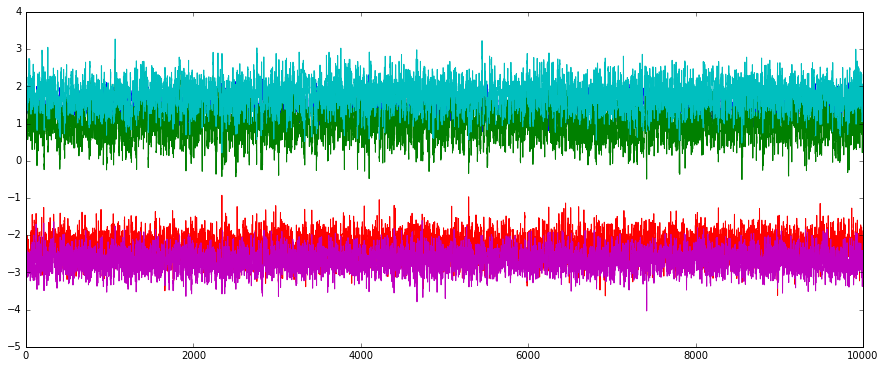

In [6]:
print "True Values:  ", true_alpha
print "MAP Estimate: ", start["coefficients"]
axs = plt.plot(trace["coefficients"])

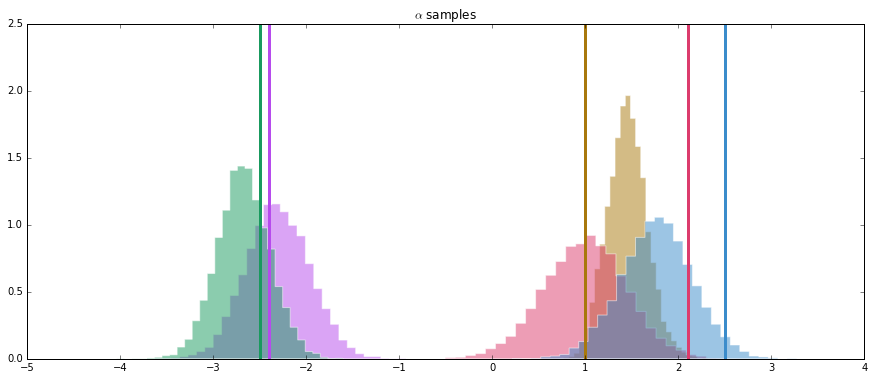

In [7]:
offset = 0.5
for coef_idx in range(5):
    color = cm.phase(coef_idx*0.2)
    bins,_,_ = plt.hist(trace["coefficients"][:,coef_idx], 30, color=color, ec="white", 
                        normed=True, alpha=0.5, histtype="stepfilled");
    plt.plot((true_alpha[coef_idx], true_alpha[coef_idx]), (0,2.5), color=color, lw=3, label="True")

ax = plt.gca()
ax.set_ylim([0, 2.5]);
ax.set_title("$\\alpha$ samples");

# Posterior predictive of standard deviation curve

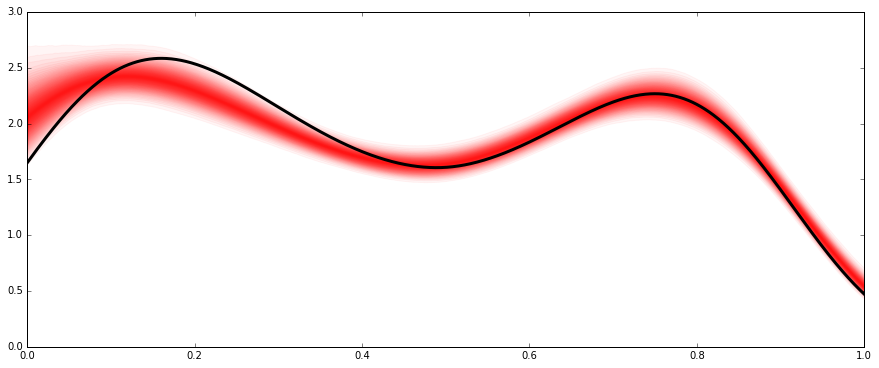

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, np.sqrt(sigma2), "k", lw=3, label="True $\sigma$")

for i in np.arange(50, 100, 1):
    tu = np.percentile(trace["sigma"], i, axis=0)
    tl = np.percentile(trace["sigma"], 100-i, axis=0)
    ax.fill_between(x, tu, tl, color="red", alpha=0.04) 